 **A]BASIC OBJECT DETECTION USING OPENCV AND HAAR CASCADES**

In [ ]:
import cv2

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
img = cv2.imread('/content/child.jfif')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

In [ ]:
for (x, y, w, h) in faces:
       cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

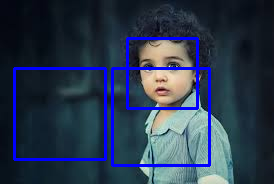

In [ ]:
from google.colab.patches import cv2_imshow

# Assuming 'img' is already read
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


**B]OBJECT DETECTION WITH YOLO (YOU ONLY LOOK ONCE)**

In [ ]:
import cv2
import numpy as np

In [ ]:
import requests

# Function to download a file from a URL
def download_file(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print(f"Downloaded {filename}")

# URLs for the YOLO files
yolov3_cfg_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
yolov3_weights_url = "https://pjreddie.com/media/files/yolov3.weights"
coco_names_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

# Download the files
download_file(yolov3_cfg_url, "yolov3.cfg")
download_file(yolov3_weights_url, "yolov3.weights")
download_file(coco_names_url, "coco.names")


Downloaded yolov3.cfg

Downloaded yolov3.weights

Downloaded coco.names


In [ ]:
# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

In [ ]:
# Load image
img = cv2.imread("/content/child.jfif")
height, width, channels = img.shape

In [ ]:
# Convert image to blob
blob = cv2.dnn.blobFromImage(img, scalefactor=1/255, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
net.setInput(blob)

In [ ]:
# Get output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
# Forward pass
outputs = net.forward(output_layers)

In [ ]:
# Process detections
boxes = []
confidences = []
class_ids = []

for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


In [ ]:
# Apply Non-Maximum Suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

# Ensure indices is a valid format
if len(indices) > 0:
    indices = indices.flatten()  # Flatten the array to get a list of indices

    for i in indices:
        box = boxes[i]
        x, y, w, h = box[0], box[1], box[2], box[3]
        label = str(classes[class_ids[i]])
        confidence = confidences[i]
        color = (0, 255, 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
else:
    print("No objects detected.")


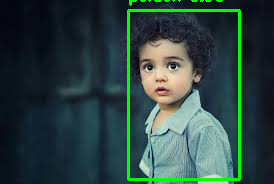

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# Display the image
cv2_imshow(img)
cv2.waitKey(0)  # This is generally not needed in Colab
cv2.destroyAllWindows()  # This is generally not needed in Colab


**c]MASK R-CNN FOR INSTANCE SEGMENTATION**


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
net = cv2.dnn.readNetFromTensorflow(
    '/kaggle/input/dataset/frozen_inference_graph.pb',
    '/kaggle/input/dataset/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt'
)


#give correct dataset and run then it will run

error: OpenCV(4.10.0) /io/opencv/modules/dnn/src/caffe/caffe_io.cpp:1138: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "/kaggle/input/dataset/frozen_inference_graph.pb" in function 'ReadProtoFromBinaryFile'


In [ ]:


img = cv2.imread('/kaggle/input/week3img/images.jfif')
height, width, _ = img.shape

# Step 4: Prepare the Image for Mask R-CNN
blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)
net.setInput(blob)

# Step 5: Forward Pass through Mask R-CNN
boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

# Step 6: Process the Output
detection_count = boxes.shape[2]
for i in range(detection_count):
    box = boxes[0, 0, i]
    class_id = int(box[1])
    score = box[2]
   
    if score > 0.5:
        x = int(box[3] * width)
        y = int(box[4] * height)
        x2 = int(box[5] * width)
        y2 = int(box[6] * height)
        roi = img[y:y2, x:x2]
        roi_height, roi_width = roi.shape[:2]
       
        mask = masks[i, class_id]
        mask = cv2.resize(mask, (roi_width, roi_height))
        mask = mask > 0.5
       
        roi[mask] = [0, 255, 0]
        img[y:y2, x:x2] = roi
       
        cv2.rectangle(img, (x, y), (x2, y2), (255, 0, 0), 2)

# Step 7: Display the Output with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()